In [40]:
# Needed on Google Colab
import os
if os.environ.get('COLAB_GPU', False):
    !pip install -U transformers
    from google.colab import drive
    drive.mount("/content/drive")

Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.4.2)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import nltk
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import warnings

pd.options.display.max_colwidth = 6000
pd.options.display.max_rows = 400
np.set_printoptions(suppress=True)
warnings.filterwarnings("ignore")
print(tf.__version__)

2.4.1


Executing this on Colab will make sure that our model runs on a TPU if available and falls back to GPU / CPU otherwise:

In [42]:
# Try to run on TPU if available
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  ['10.49.166.194:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.49.166.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.49.166.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In our case, we are running on a TPU with eight cores. This will give us an immense speed up!  
As before, we first download and extract our data:

In [43]:
# store current path and download and extract data there
CURR_PATH = !pwd

In [44]:
# PARAMETERS
PATH_DATA = CURR_PATH[0]
PATH_GDRIVE_TMP = "/content/drive/MyDrive/tmp/"  # Google Drive

Let's load the data set and create our target variable. Positive ratings (one or two) will be considered as good and negative ones (five or six) as negative. As before, we ignore neutral ratings:

In [45]:
# read data from csv
data = pd.read_csv(PATH_GDRIVE_TMP + "only_lockdown.csv", sep='\t', header=None, skiprows=[0])

# Create binary grade, class 1-2 or 5-6  = good or bad
data["opinion_integer"] = 0
data.loc[data[6] == '-', "opinion_integer"] = 0
data.loc[data[6] == 'o', "opinion_integer"] = 1
data.loc[data[6] == '+', "opinion_integer"] = 2

data.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,opinion_integer
0,-,x,x,x,-,-,-,29137,2020_03_15,16,NEOS,Abgeordneter Josef Schellhorn (NEOS),False,"Das heißt, diese Planbarkeit ist jetzt gar nicht machbar – für Sie nicht –, nur die Unternehmer kommen mit dieser Unplanbarkeit gar nicht zurecht, weil dieser Lockdown ja jetzt nur für eine Woche bestimmt ist.",0
1,-,x,-,x,x,-,-,31054,2020_03_20,19,NEOS,"Abgeordnete Mag. Beate Meinl-Reisinger, MES (NEOS)",False,"Wie und wann schaffen wir es, aus diesem Lockdown wieder herauszukommen, ohne die Gesundheit der Menschen in Österreich oder auch europaweit aufs Spiel zu setzen?",0
2,-,#,#+,-,x,-,-,32973,2020_04_03,22,ÖVP,Abgeordneter August Wöginger (ÖVP),True,"Kickl hat am 13. März von einem Lockdown gesprochen – also alles zudrehen, nichts geht mehr in diesem Land.",0
3,+,x,+,x,x,+,+,34265,2020_04_03,22,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Ich möchte gleich zu Beginn eines klarstellen, damit es keine Missverständnisse gibt: Ja, der Lockdown war richtig.",2
4,+,x,x,x,o,o,-,34269,2020_04_03,22,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Lassen Sie mich aber mit dem Gemeinsamen beginnen: Was das Ziel betrifft, sind wir uns ja alle einig: Es geht um nichts Geringeres als das Einpendeln unserer Volks­wirtschaft auf ein Level, wie es vor der Krise war, oder, wenn Sie so wollen, wenn man jetzt den Lockdown schrittweise lockert, dass dann das Wirtschaftssystem eigentlich genauso aussieht, wie es vor der Krise war.",0
5,+,x,x,x,+s,o,o,34709,2020_04_03,22,NEOS,Abgeordnete Mag. Martina Künsberg Sarre (NEOS),False,"Regelmäßige begleitende Datenerhe­bun­gen in dieser Phase des Lockdowns, in der Lehrer_innen, Schüler_innen und Eltern auf digitales Unterrichten und Lernen absolut angewiesen sind, können einen wesent­lichen Beitrag für eine effiziente Digitalisierung des Bildungssystems in der Zukunft leisten.",1


In [46]:
nltk.download("stopwords")
nltk.download("punkt")
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))


def clean_text(text, for_embedding=False):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemm
    """
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        # no stemming, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_filtered = [
            stemmer.stem(word) for word in words_tokens_lower if word not in stop_words
        ]

    text_clean = " ".join(words_filtered)
    return text_clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Now, we can we apply this pre-processing and cleaning to our original data:

In [47]:
%%time
# Clean Comments
data["comment_clean"] = data.loc[data[13].str.len() > 20, 13]
data["comment_clean"] = data["comment_clean"].map(
    lambda x: clean_text(x, for_embedding=True) if isinstance(x, str) else x
)

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 143 ms


This is how the final comments will look like:

In [48]:
data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,opinion_integer,comment_clean
0,-,x,x,x,-,-,-,29137,2020_03_15,16,NEOS,Abgeordneter Josef Schellhorn (NEOS),False,"Das heißt, diese Planbarkeit ist jetzt gar nicht machbar – für Sie nicht –, nur die Unternehmer kommen mit dieser Unplanbarkeit gar nicht zurecht, weil dieser Lockdown ja jetzt nur für eine Woche bestimmt ist.",0,"Das heißt , diese Planbarkeit ist jetzt gar nicht machbar für Sie nicht , nur die Unternehmer kommen mit dieser Unplanbarkeit gar nicht zurecht , weil dieser Lockdown ja jetzt nur für eine Woche bestimmt ist ."
1,-,x,-,x,x,-,-,31054,2020_03_20,19,NEOS,"Abgeordnete Mag. Beate Meinl-Reisinger, MES (NEOS)",False,"Wie und wann schaffen wir es, aus diesem Lockdown wieder herauszukommen, ohne die Gesundheit der Menschen in Österreich oder auch europaweit aufs Spiel zu setzen?",0,"Wie und wann schaffen wir es , aus diesem Lockdown wieder herauszukommen , ohne die Gesundheit der Menschen in Österreich oder auch europaweit aufs Spiel zu setzen ?"
2,-,#,#+,-,x,-,-,32973,2020_04_03,22,ÖVP,Abgeordneter August Wöginger (ÖVP),True,"Kickl hat am 13. März von einem Lockdown gesprochen – also alles zudrehen, nichts geht mehr in diesem Land.",0,"Kickl hat am . März von einem Lockdown gesprochen also alles zudrehen , nichts geht mehr in diesem Land ."
3,+,x,+,x,x,+,+,34265,2020_04_03,22,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Ich möchte gleich zu Beginn eines klarstellen, damit es keine Missverständnisse gibt: Ja, der Lockdown war richtig.",2,"Ich möchte gleich zu Beginn eines klarstellen , damit es keine Missverständnisse gibt Ja , der Lockdown war richtig ."
4,+,x,x,x,o,o,-,34269,2020_04_03,22,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Lassen Sie mich aber mit dem Gemeinsamen beginnen: Was das Ziel betrifft, sind wir uns ja alle einig: Es geht um nichts Geringeres als das Einpendeln unserer Volks­wirtschaft auf ein Level, wie es vor der Krise war, oder, wenn Sie so wollen, wenn man jetzt den Lockdown schrittweise lockert, dass dann das Wirtschaftssystem eigentlich genauso aussieht, wie es vor der Krise war.",0,"Lassen Sie mich aber mit dem Gemeinsamen beginnen Was das Ziel betrifft , sind wir uns ja alle einig Es geht um nichts Geringeres als das Einpendeln unserer Volks wirtschaft auf ein Level , wie es vor der Krise war , oder , wenn Sie so wollen , wenn man jetzt den Lockdown schrittweise lockert , dass dann das Wirtschaftssystem eigentlich genauso aussieht , wie es vor der Krise war ."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,+,x,x,x,+,o,+,140987,2020_11_26,67,Grüne,Abgeordnete Dr. Elisabeth Götze (Grüne),True,"Wegen des aktuellen Lockdowns hat das Wifo die Prognose revidiert, daher wird im Vergleich zum Bundesfinanzrahmengesetz vergangene Woche jetzt noch mehr Geld für die Menschen – für Soziales und für Arbeit – vorgesehen, für die Unterstützung von Be­troffenen dieser Coronakrise.",2,"Wegen des aktuellen Lockdowns hat das Wifo die Prognose revidiert , daher wird im Vergleich zum Bundesfinanzrahmengesetz vergangene Woche jetzt noch mehr Geld für die Menschen für Soziales und für Arbeit vorgesehen , für die Unterstützung von Be troffenen dieser Coronakrise ."
488,-,x,x,x,-,o,-,141109,2020_11_26,67,NEOS,Abgeordnete Dipl.-Ing. Karin Doppelbauer (NEOS),False,"Noch einmal: Ich bin auch der Meinung meiner Kolleginnen und Kollegen von der Oppo­sition, dass der harte Lockdown, der in dieses Budget 2021 nicht eingepreist ist, natürlich hätte eingepreist werden sollen.",0,"Noch einmal Ich bin auch der Meinung meiner Kolleginnen und Kollegen von der Oppo sition , dass der harte Lockdown , der in dieses Budget nicht eingepreist ist , natürlich hätte eingepreist werden sollen ."
489,-,x,x,-,x,o,-,141310,2020_11_26,67,FPÖ,Abgeordneter Michael Schnedlitz (FPÖ),False,Sie haben ja zum Beispiel durch den Lockdown und die überbordenden Maßnah­men durch die Hintertür das größte Amazon-Förderpaket der Geschichte geschaffen.,0,Sie haben 

In [49]:
data['totalwords'] = data['comment_clean'].str.count(' ') + 1

In [50]:
data['totalwords'].max()

121

In [51]:
# Drop Missing
data = data.dropna(axis="index", subset=["opinion_integer", "comment_clean"]).reset_index(
    drop=True
)
data = data[["comment_clean", "opinion_integer"]]
data.columns = ["text", "label"]
data.head(2)
data.to_csv(PATH_GDRIVE_TMP + "only_lockdown_pp.csv", index=False)

In [52]:
# skip pre processing if done before
#data = pd.read_csv(PATH_GDRIVE_TMP + "only_lockdown_pp.csv")

### A brief background on transformers and BERT

You've made it to the interesting part. But before we further dive into the code, let's get a brief background on transformers and BERT. Transformer models, similar to RNNs (e.g. the LSTM we used in [part 2]({filename}/doctors_nlp2.ipynb)), are designed to handle sequences of data well. They shine at picking up relations between various inputs in an input sequence. Hence, they lend themselves perfectly for NLP tasks where such associations correspond to semantic relationships. This is also a convenient property of LSTM models, e.g. the one we implemented previously. It was able to learn relationships between sequences of the input, e.g. word vectors. For LSTMs, however, this ability is limited. Because inputs are processed in sequence, in practice, at the end of a long sentence information from the beginning will often be lost. Also, computational limits come into play really quick for the same reason. Transformer models address this issue by using the so called `attention` mechanism. This allows them to process inputs in a non sequential way which allows for better parallelization. Following, computational efficiency is greatly improved. In addition, they learn associations between words even if those are far apart in a sentence. This is an outstanding improvement when trying to model language. It explains why transformers are at the foundation of most state of the art models and why they have surpassed former architectures like LSTMs.  
BERT is currently one of the most successful transformer architectures (although, this will change quickly as the speed of innovation at the moment is mind blowing). For a well illustrated and thorough introduction, check out [this article](http://jalammar.github.io/illustrated-bert/) by Jay Allamar. BERT has been developed by Google and has set new records on several language related tasks. Its main novelty is the introduction of bi-directionality. Previous models looked at inputs uni directionally, i.e. from left to right. In contrast, BERT also looks at them from right to left. The authors have proved that this leads to a deeper understanding of context in texts and increases performance significantly.  
As most other state of the art models, a lot of BERT's performance comes from sheer size. BERT large (24 layers, 16 attention heads, 340 million parameters) is trained on a huge text dataset in order to gain a thorough understanding of language in general. For this, it follows several ingenious unsupervised training strategies. Training such models is extremely computationally demanding and expensive. For all but big institutions and companies it is prohibitory.  
Fortunately, we can apply the principle of transfer learning to such models. That is, we can fine tune a pre trained model on a more specific task and dataset (which doesn't need to be that huge). In our case, we will simply add a classification layer to the pre trained BERT model. Then, we will do a supervised training on our labeled dataset. Consequently, we will mainly train our classifier layer while most other layers will only be minimally impacted. In a sense, we use the general language understanding of the pre trained model and improve its understanding of our unique domain. Moreover, we teach it to solve a specific task. In our case, this will be sentiment analysis in the form of a binary text classification.

### Feture Creation and Modeling

As mentioned before, we use the [`transformers`](https://github.com/huggingface/transformers) library. To stay consistent with our previous neural network model, we use the Tensorflow 2.0 implementation. In addition, this allows us to use the TPU on Google Colab without much trouble. Another invaluable advantage of the transformers library, is that several pre trained models are readily available for usage.  
BERT comes with its own Tokenizer. As with the model itself, we will use a pre trained version of the tokenizer. Here, we use a variant that has been specifically trained on German texts and made public. Hence, it already comes with a huge German vocabulary:



In [53]:
# this will download and initialize the pre trained tokenizer
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

The inputs expected by BERT are very similar to the ones we've used before: they are just vectors containing integers which can be mapped to tokens by using a dictionary. The only difference is that BERT expects several "special" tokens. `[CLS]` stands for classification and marks the beginning of a new input to be classified. `[SEP]` marks the separation between sentences. Finally, `[PAD]` is used as a placeholder in order to pad all vectors to the same fixed length. The helper method `encode_plus` of the `Tokenizer` object deals with creating the numeric vectors while taking care of the extra tokens: 



In [54]:
MAXLEN = 128
#MAXLEN = 256

def preprocess_text(data):
    """ take texts and prepare as input features for BERT 
    """
    input_ids = []
    # For every sentence...
    for comment in data:
        encoded_sent = tokenizer.encode_plus(
            text=comment,
            add_special_tokens=True,  # Add `[CLS]` and `[SEP]`
            max_length=MAXLEN,  # Max length to truncate/pad
            pad_to_max_length=True,  # Pad sentence to max length
            return_attention_mask=False,  # attention mask not needed for our task
        )
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get("input_ids"))
    return input_ids

Before creating our features, let's check out the workings of the tokenizer with an example:

In [55]:
# Original Comment and encoding outputs
comment = ["Bedingt durch die Maßnahmen der ÖVP Grüne Bundesregierung, insbesondere der neuerliche Lockdown im November lassen die Einnahmen ganzer Branchen wegbrechen."]
input_ids = preprocess_text(comment)
print("Comment: ", comment)
print("Tokenized Comment: ", tokenizer.convert_ids_to_tokens(input_ids[0])[0:20])
print("Token IDs: ", input_ids[0][0:20])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Comment:  ['Bedingt durch die Maßnahmen der ÖVP Grüne Bundesregierung, insbesondere der neuerliche Lockdown im November lassen die Einnahmen ganzer Branchen wegbrechen.']
Tokenized Comment:  ['[CLS]', 'Beding', '##t', 'durch', 'die', 'Maßnahmen', 'der', 'ÖVP', 'Grüne', 'Bundesregierung', ',', 'insbesondere', 'der', 'neuer', '##liche', 'Lock', '##down', 'im', 'November', 'lassen']
Token IDs:  [3, 14560, 26901, 261, 30, 3406, 21, 26318, 14134, 4260, 26918, 1831, 21, 4201, 322, 22158, 21646, 106, 1324, 1641]


First, you can see the special tokens being automatically added in the right places. Second, we see that some tokens simply correspond to regular words, i.e. "Ich" and "liebe". This will be the case for all words that are in the vocabulary. Here, that will amount to most regular German words. In contrast, unknown words get a special treatment. Instead of just being left out, as was the case with the FastText embeddings, they are split to shorter character sequences. For example "data", which is not a German word, becomes "dat" and "##a". This allows the model to still use these novel words.  
There is one more major difference between BERT's word embeddings and e.g. FastText's. Recall how vector representations of words with similar semantic meaning in FastText were similar, i.e. had a short distance between them. This allowed our model to group similar words together. BERT takes this one step further. A word's vector representation is not static anymore but depends on context. Consequently, the vector for "broke" is different when it's in a context of "money" vs. " a record". This immensely improves contextual awareness and might benefit predictions in many cases.  
Now, we apply the tokenization process to our data:

In [56]:
%%time
import pickle

input_ids = preprocess_text(data["text"])
# tokenization takes quite long
# we can save the result and load it quickly via pickle
pickle.dump(input_ids, open(PATH_GDRIVE_TMP + "input_ids_lockdown.pkl", "wb"))
# input_ids = pickle.load(open(PATH_GDRIVE_TMP+"/input_ids.pkl", "rb"))

CPU times: user 437 ms, sys: 0 ns, total: 437 ms
Wall time: 439 ms


Next, we split out data into train and test for cross validation:

In [57]:
# Sample data for cross validation
train_ids, test_ids, train_labels, test_labels = train_test_split(
    input_ids, data["label"], test_size=0.15, shuffle=True
)
print(f"Train set: {len(train_ids)}\nTest set: {len(test_ids)}")

Train set: 418
Test set: 74


Here, we set the model parameters. `MAXLEN` is the max. number of tokens in our input. Longer inputs will be truncated to this. While greater lengths will yield better predictions, they also mean a greater computational toll. We differentiate between `BATCH_SIZE_PER_REPLICA` and `BATCH_SIZE` when we run on multiple GPUs or TPUs, as is the case on Google Colab. Each TPU core will deal with `BATCH_SIZE_PER_REPLICA` batches at a time. `EPOCHS` is simply the number of training iterations over the whole training set:

In [58]:
strategy.num_replicas_in_sync

8

In [59]:
# Set Model Parameters
MAXLEN = MAXLEN
BATCH_SIZE_PER_REPLICA = 8
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
EPOCHS = 8
LEARNING_RATE = 1e-5
DATA_LENGTH = len(data)

As a last step before building our model, we need to prepare our dataset. Before, we used NumPy arrays as inputs. Here, we use the `tf.data.Dataset` class which offers several convenient methods:

In [60]:
def create_dataset(
    data_tuple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    buffer_size=DATA_LENGTH,
    train=False,
):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(
            buffer_size=buffer_size, reshuffle_each_iteration=True
        ).repeat(epochs)
    dataset = dataset.batch(batch_size)
    return dataset


train = create_dataset(
    (train_ids, train_labels), buffer_size=len(train_ids), train=True
)
test = create_dataset((test_ids, test_labels), buffer_size=len(test_ids))

Finally, we define a function that returns our model architecture:

In [61]:
def build_model(transformer, max_len=MAXLEN):
    """ add binary classification to pretrained model
    """
    input_word_ids = tf.keras.layers.Input(
        shape=(max_len,), dtype=tf.int32, name="input_word_ids"
    )
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = tf.keras.layers.Dense(3, activation="sigmoid")(cls_token)
    model = tf.keras.models.Model(inputs=input_word_ids, outputs=out)
    model.compile(
        tf.keras.optimizers.Adam(lr=LEARNING_RATE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In the first step, we define an `Input` layer which expects our numeric vectors as input. Then, we add the pre trained transformer which receives the inputs from the previous layer. The output of the transformer is then fed into a `Dense` layer which finally outputs a probability for our input belonging to class 0 or 1.  
Now, we build our model by first downloading the pre trained BERT and passing it to our `build_model` function:

In [62]:
with strategy.scope():
    transformer_layers = TFBertModel.from_pretrained("bert-base-german-cased")
    model = build_model(transformer_layers, max_len=MAXLEN)
model.summary()

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 128)]             0         
_________________________________________________________________
tf_bert_model_2 (TFBertModel TFBaseModelOutputWithPool 109081344 
_________________________________________________________________
tf.__operators__.getitem_2 ( (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 2307      
Total params: 109,083,651
Trainable params: 109,083,651
Non-trainable params: 0
_________________________________________________________________


In total we have almost 110 Mio. trainable parameters. It's convenient that almost all of them have already been trained. Because we use the pre trained weights for them, they will only need to change ever so slightly. Still, it is a big model and even training on GPUs takes considerable time. So again, good thing that we can use TPUs.  
Next, we define callbacks that will be used during training. The `EartlyStopping` callback will stop the training if validation loss stops decreasing between epochs. This avoids overfitting. `ModelCheckpoint` saves checkpoints of the model after each epoch, so that training can be resumed. On Google Colab, you can currently only save TPU models in a Cloud Bucket but not on a mounted Google Drive. Hence, I commented out that part:

In [63]:
# Stop training when validation acc starts dropping
# Save checkpoint of model each period
now = datetime.now().strftime("%Y-%m-%d_%H%M")
# Create callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=1, restore_best_weights=True
    ),
    # tf.keras.callbacks.ModelCheckpoint(
    #    PATH_GDRIVE_TMP + now + "_Model_{epoch:02d}_{val_loss:.4f}.h5",
    #    monitor="val_loss",
    #    save_best_only=True,
    #    verbose=1,
    # ),
]

Finally, time to get excited! We can now start the model training:

In [64]:
%%time
# Train using appropriate steps per epochs (go through all train data in an epoch)
steps_per_epoch = int(np.floor((len(train_ids) / BATCH_SIZE)))
print(
    f"Model Params:\nbatch_size: {BATCH_SIZE}\nEpochs: {EPOCHS}\n"
    f"Step p. Epoch: {steps_per_epoch}\n"
    f"Learning rate: {LEARNING_RATE}"
)
hist = model.fit(
    train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=test,
    verbose=1,
    #callbacks=callbacks,
)

Model Params:
batch_size: 64
Epochs: 8
Step p. Epoch: 6
Learning rate: 1e-05
Epoch 1/8


6/6 [==============================] - ETA: 0s - loss: 1.4880 - accuracy: 0.3536WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


6/6 [==============================] - 90s 3s/step - loss: 1.4654 - accuracy: 0.3596 - val_loss: 0.8915 - val_accuracy: 0.6216
Epoch 2/8
6/6 [==============================] - 1s 243ms/step - loss: 1.0212 - accuracy: 0.5477 - val_loss: 0.9060 - val_accuracy: 0.6216
Epoch 3/8
6/6 [==============================] - 1s 253ms/step - loss: 0.9794 - accuracy: 0.5602 - val_loss: 0.8857 - val_accuracy: 0.6216
Epoch 4/8
6/6 [==============================] - 1s 248ms/step - loss: 0.9980 - accuracy: 0.5196 - val_loss: 1.0080 - val_accuracy: 0.5676
Epoch 5/8
6/6 [==============================] - 1s 248ms/step - loss: 0.9193 - accuracy: 0.6161 - val_loss: 0.8803 - val_accuracy: 0.6351
Epoch 6/8
6/6 [==============================] - 1s 249ms/step - loss: 0.9064 - accuracy: 0.6358 - val_loss: 0.9152 - val_accuracy: 0.6216
Epoch 7/8
6/6 [==============================] - 1s 247ms/step - loss: 0.8949 - accuracy: 0.5714 - val_loss: 0.8528 - val_accuracy: 0.6757
Epoch 8/8
6/6 [========================

The model converges really fast and stops early after only three epochs. This is because it already achieves the lowest validation loss in the second period:

[Text(0, 0.5, ''),
 [Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8')],
 Text(0.5, 1.0, 'Model loss')]

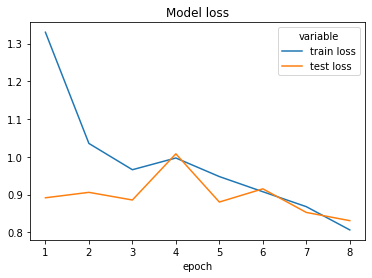

In [65]:
loss = pd.DataFrame(
    {"train loss": hist.history["loss"], "test loss": hist.history["val_loss"]}
).melt()
loss["epoch"] = loss.groupby("variable").cumcount() + 1
sns.lineplot(x="epoch", y="value", hue="variable", data=loss).set(
    title="Model loss",
    ylabel="",
    xticks=range(1, loss["epoch"].max() + 1),
    xticklabels=loss["epoch"].unique(),
)

Since the low loss value indicates that our model is already really good, we don't do any hyperparameter tuning. Also, our parameters were already chosen with good care. However, when looking for peak performance, it would be reasonable to compare different configurations. Natural starting points would be to:
1. Increasing the input length
2. Change the learning rate or use a dynamic rate adaption
3. Try different batch sizes

I'd expect to see some further but very marginal improvement from these steps.

### Evaluation 

Was this all worth it? Let's find out:

In [66]:
# predict on test set
pred = model.predict(test, batch_size=BATCH_SIZE, verbose=2, use_multiprocessing=True)

2/2 - 14s


In [67]:
np.argmax(pred, axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [68]:
# Load best model from Checkpoint
# model = load_model(PATH_GDRIVE_TMP+"BERT.h5", compile=False)
pred_class = np.argmax(pred, axis=-1)
report = metrics.classification_report(test_labels, pred_class)
print(report)

              precision    recall  f1-score   support

           0       0.69      0.98      0.81        45
           1       0.50      0.16      0.24        19
           2       0.50      0.20      0.29        10

    accuracy                           0.66        74
   macro avg       0.56      0.45      0.44        74
weighted avg       0.61      0.66      0.59        74



Let's recap our previous results: In [the first part]({filename}/doctors_nlp1.ipynb) we used a traditional classification method and achieved a decent macro f1-score of `0.9`. In [part two]({filename}/doctors_nlp1.ipynb), we improved the score to `0.93` using a LSTM neural network and FastText word embeddings. For our harder to predict class 1 (bad ratings), we had a precision of `0.86` and recall of `0.89`.  
Compared to that, our BERT approach is a significant improvement. We increase the macro f1 to `0.94` while getting a decent improvement in both, the precision and recall for class 1 . You might be fooled by the small increase of the absolute numbers and wonder why I'm talking about "big improvement". Well, we really need to put this into relation. The better a model already performs, the harder it gets to squeeze out further improvements. An increase from a f1 of `0.6` to `0.7` is usually easier to achieve and less impressive than an improvement from `0.95` to `0.97`. Think "pareto principle" and "decreasing marginal returns"! 
